<a href="https://colab.research.google.com/github/MasumiYano/oh-here-is-waldo/blob/main/oh_here_is_waldo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔍 Where's Waldo Detection Project

This notebook implements a VGG16-based neural network to detect Waldo in images.
The model performs both classification (Waldo present/absent) and bounding box regression.

## 🚀 Features:
- VGG16 backbone for feature extraction
- Dual-head architecture (classification + bounding box regression)
- Data augmentation for better generalization
- Real-time training visualization

## 📝 Instructions:
1. Run each cell in order
2. Upload your data when prompted
3. Monitor training progress
4. Download trained model at the end


In [91]:
# Quick Memory Fix
import gc
gc.collect()

# Clear GPU memory
torch.cuda.empty_cache()
torch.cuda.synchronize()

# Set memory limit
torch.cuda.set_per_process_memory_fraction(0.7)  # Use only 70% of GPU

print("GPU memory cleared and limited to 70%")

GPU memory cleared and limited to 70%


In [92]:
!rm -rf /content/data/

In [93]:
# Setup and Install Dependencies
print("Setting up environment...")

# Install required packages
!pip install torch torchvision opencv-python-headless matplotlib pillow numpy scikit-learn -q

# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

Setting up environment...
PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla T4


In [94]:
# Configuration
# All configuration constants in one place

# Image dimensions
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64

# Training configuration
EPOCH = 300
BATCH_SIZE = 8
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.01

# Data split ratios
TRAIN_SPLIT = 0.7
TEST_SPLIT = 0.3

# Augmentation parameters
AUGMENTATION_PROBABILITY = 0.5

# Model parameters
NUM_CLASSES = 2  # Waldo present (1) or absent (0)

print("Configuration loaded:")
print(f"   - Image size: {IMAGE_WIDTH}x{IMAGE_HEIGHT}")
print(f"   - Epochs: {EPOCH}")
print(f"   - Device: {device}")

Configuration loaded:
   - Image size: 64x64
   - Epochs: 300
   - Device: cuda


In [95]:
# Import All Required Libraries
import os
import glob
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

print("All libraries imported successfully!")

All libraries imported successfully!


In [96]:
# Utility Functions
# All utility functions combined from utils.py

# Define transforms for data augmentation
transform = T.Compose([
    T.ToPILImage(),
    T.RandomHorizontalFlip(p=1.0),
    T.ColorJitter(hue=0.1, brightness=0.1, contrast=0.1, saturation=0.1),
    T.ToTensor(),
    T.ToPILImage(),
])

def show_image(image_dict, json_data):
    """Display up to 4 images with their annotations."""
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    image_counter = 0

    for file_name, img_arr in image_dict.items():
        if image_counter >= 4:
            break

        # Find corresponding annotation
        for data in json_data:
            if data.get("bg_name") == file_name:
                if data.get("class") == 0:
                    # No Waldo - just show image
                    ax[image_counter].imshow(img_arr)
                    ax[image_counter].set_title(f'{file_name} (No Waldo)')
                else:
                    # Waldo present - draw bounding box
                    bbox = data.get("bbox")
                    if bbox:
                        img_with_bbox = cv2.rectangle(
                            img_arr.copy(),
                            (bbox[0], bbox[1]),
                            (bbox[2], bbox[3]),
                            (255, 0, 0), 2
                        )
                        ax[image_counter].imshow(img_with_bbox)
                        ax[image_counter].set_title(f'{file_name} (Waldo)')
                    else:
                        ax[image_counter].imshow(img_arr)
                        ax[image_counter].set_title(f'{file_name} (Waldo - No BBox)')

                ax[image_counter].axis('off')
                image_counter += 1
                break

    # Hide unused subplots
    for i in range(image_counter, 4):
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

def load_json(json_file):
    """Load JSON file and return data."""
    try:
        with open(json_file, 'r') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"Warning: {json_file} not found. Returning empty list.")
        return []
    except json.JSONDecodeError:
        print(f"Warning: Error decoding {json_file}. Returning empty list.")
        return []

def update_bbox_after_flip(bbox, img_width):
    """Update bounding box coordinates after horizontal flip."""
    x1, y1, x2, y2 = bbox
    new_x1 = img_width - x2
    new_x2 = img_width - x1
    return [new_x1, y1, new_x2, y2]

def augment_image(image_dict, json_data):
    """Apply data augmentation to images and update annotations accordingly."""
    updated_json_data = json_data.copy()
    new_images = {}

    print("Applying data augmentation...")
    augmentation_count = 0

    for file_name, img_arr in image_dict.items():
        # Convert numpy array to PIL image for torchvision transforms
        if img_arr.dtype != np.uint8:
            img_arr = (img_arr * 255).astype(np.uint8)

        # With 50% probability, apply augmentation
        if np.random.rand() < 0.5:
            try:
                # Apply the augmentation
                augmented_img = transform(img_arr)
                augmented_img_arr = np.array(augmented_img)

                # Create a new file name for the augmented image
                augmented_file_name = f"{file_name}_augmented"
                new_images[augmented_file_name] = augmented_img_arr
                augmentation_count += 1

                # Find the corresponding data in the JSON file
                for data in json_data:
                    if data.get("bg_name") == file_name:
                        # Copy the original data for the new augmented image entry
                        augmented_data = data.copy()
                        augmented_data["bg_name"] = augmented_file_name

                        # If the class is 1 (Waldo present), update the bounding box
                        if data.get("class") == 1 and data.get("bbox"):
                            bbox = data.get("bbox")
                            img_width = augmented_img_arr.shape[1]
                            updated_bbox = update_bbox_after_flip(bbox, img_width)
                            augmented_data['bbox'] = updated_bbox

                        # Add the augmented data to the updated JSON data
                        updated_json_data.append(augmented_data)
                        break

            except Exception as e:
                print(f"Warning: Failed to augment {file_name}: {e}")
                continue

    print(f"Successfully augmented {augmentation_count} images")

    # Update the original image_dict with the new images
    image_dict.update(new_images)

    # Shuffle the image_dict
    items = list(image_dict.items())
    random.shuffle(items)
    shuffled_image_dict = dict(items)

    # Save the updated JSON file
    try:
        with open('/content/updated_annotations.json', 'w') as json_file:
            json.dump(updated_json_data, json_file, indent=4)
        print("Updated annotations saved")
    except Exception as e:
        print(f"Warning: Failed to save updated annotations: {e}")

    return shuffled_image_dict

def get_name(img_name, json_data):
    """Get class and bounding box information for a given image name."""
    for data in json_data:
        if data.get("bg_name") == img_name:
            class_label = data.get("class", 0)

            if class_label == 1:
                bbox_label = data.get("bbox", [0, 0, 0, 0])
                return class_label, bbox_label
            else:
                return class_label, [0, 0, 0, 0]

    # If image not found in annotations, assume no Waldo
    return 0, [0, 0, 0, 0]

def plot_graph(step_losses, step_accuracies):
    """Plot training loss and accuracy graphs."""
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(step_losses, label="Training Loss", color='blue')
    plt.xlabel('Steps (x50)')
    plt.ylabel('Loss')
    plt.title("Training Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(step_accuracies, label="Training Accuracy", color='green')
    plt.xlabel('Steps (x50)')
    plt.ylabel('Accuracy')
    plt.title("Training Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def calculate_accuracy(class_pred, class_true):
    """Calculate classification accuracy."""
    predicted_classes = torch.argmax(class_pred, dim=1)
    correct = (predicted_classes == class_true).float()
    accuracy = correct.mean().item()
    return accuracy

def convert_to_tensor(image_dict, json_data, device):
    """Convert image dictionary to tensors and prepare labels."""
    tensor_dict = {}
    labels_dict = {}

    for filename, img_array in image_dict.items():
        # Convert image to tensor and normalize
        img_tensor = torch.from_numpy(img_array).float() / 255.0

        # Handle different array shapes (H, W, C) -> (C, H, W)
        if len(img_tensor.shape) == 3:
            img_tensor = img_tensor.permute(2, 0, 1)

        # Add batch dimension and move to device
        img_tensor = img_tensor.unsqueeze(0).to(device)
        tensor_dict[filename] = img_tensor

        # Get labels
        class_label, bbox_label = get_name(filename, json_data)

        # Convert labels to tensors
        if isinstance(class_label, (list, tuple)):
            class_tensor = torch.tensor(class_label[0]).long().to(device)
        else:
            class_tensor = torch.tensor(class_label).long().to(device)

        if isinstance(bbox_label, (list, tuple)):
            bbox_tensor = torch.tensor(bbox_label).float().to(device)
        else:
            bbox_tensor = torch.tensor([0, 0, 0, 0]).float().to(device)

        labels_dict[filename] = (class_tensor, bbox_tensor)

    return tensor_dict, labels_dict

print("Utility functions loaded!")

Utility functions loaded!


In [97]:
# Model Definition
# VGG16 model and loss functions from models.py

criterion_classification = nn.CrossEntropyLoss()
criterion_regression = nn.SmoothL1Loss()

def compute_loss(class_pred, class_true, bbox_pred, bbox_true):
    """Compute combined classification and bounding box loss."""
    classification_loss = criterion_classification(class_pred, class_true)

    iou = calculate_iou(bbox_pred, bbox_true)
    bbox_loss = 1 - iou.mean()

    total_loss = classification_loss + 0.5 * bbox_loss
    return total_loss

def calculate_iou(bbox_pred, bbox_true):
    """Calculate Intersection over Union (IoU) for bounding boxes."""
    # Intersection coordinates
    x1 = torch.max(bbox_pred[:, 0], bbox_true[:, 0])
    y1 = torch.max(bbox_pred[:, 1], bbox_true[:, 1])
    x2 = torch.min(bbox_pred[:, 2], bbox_true[:, 2])
    y2 = torch.min(bbox_pred[:, 3], bbox_true[:, 3])

    # Calculate intersection area
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # Calculate areas of both bounding boxes
    bbox_pred_area = (bbox_pred[:, 2] - bbox_pred[:, 0]) * (bbox_pred[:, 3] - bbox_pred[:, 1])
    bbox_true_area = (bbox_true[:, 2] - bbox_true[:, 0]) * (bbox_true[:, 3] - bbox_true[:, 1])

    # Calculate union area
    union = bbox_pred_area + bbox_true_area - intersection

    # Calculate IoU, add small epsilon to avoid division by zero
    iou = intersection / union.clamp(min=1e-6)
    return iou

class VGG16(nn.Module):
    def __init__(self, device, num_class):
        super(VGG16, self).__init__()
        self.device = device
        self.num_class = num_class

        # Same conv blocks as before
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(256, self.num_class)
        )

        self.bbox_regressor = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = torch.flatten(x, 1)
        class_out = self.classifier(x)
        bbox_out = self.bbox_regressor(x)
        return class_out, bbox_out

print("Model definition loaded!")

Model definition loaded!


In [98]:
# Image Preprocessing Class
# ImagePreprocessing class from image_preprocessing.py

class ImagePreprocessing:
    """Handle image preprocessing for Waldo detection."""
    def __init__(self):
        self.image_width = IMAGE_WIDTH
        self.image_height = IMAGE_HEIGHT
        self.waldo_path = "/content/data/waldo.png"
        self.waldo = None
        self.background_paths = []
        self.resized_backgrounds = []
        self.waldo_and_backgrounds = {}

    def load_waldo(self):
        """Load and resize Waldo image."""
        try:
            self.waldo = Image.open(self.waldo_path)
            waldo_width, waldo_height = self.waldo.size

            if waldo_width > self.image_width or waldo_height > self.image_height:
                factor = min(
                    (self.image_width * 0.2) / waldo_width,
                    (self.image_height * 0.2) / waldo_height
                )
                self.waldo = self.waldo.resize(
                    (int(waldo_width * factor), int(waldo_height * factor)),
                    Image.LANCZOS
                )
            print(f"Waldo loaded and resized to {self.waldo.size}")
        except Exception as e:
            print(f"Error loading Waldo: {e}")
            return False
        return True

    def load_backgrounds(self):
        """Load background images."""
        bg_patterns = ['/content/data/images/*.jpg', '/content/data/images/*.jpeg', '/content/data/images/*.png']
        self.background_paths = []

        for pattern in bg_patterns:
            self.background_paths.extend(glob.glob(pattern))

        print(f"📁 Found {len(self.background_paths)} background images")
        return len(self.background_paths) > 0

    def resize_background(self):
        """Resize all background images to target dimensions."""
        if not self.background_paths:
            print("No background images found")
            return False

        print("Resizing background images...")
        self.resized_backgrounds = []

        for background in self.background_paths:
            try:
                bg_img = Image.open(background)
                bg_width, bg_height = bg_img.size

                if bg_width != self.image_width or bg_height != self.image_height:
                    resized_bg = bg_img.resize(
                        (self.image_width, self.image_height),
                        Image.LANCZOS
                    )
                else:
                    resized_bg = bg_img.copy()

                self.resized_backgrounds.append((resized_bg, background))
            except Exception as e:
                print(f"Error processing {background}: {e}")
                continue

        print(f"Successfully resized {len(self.resized_backgrounds)} images")
        return True

    def place_waldo_on_bg(self):
        """Place Waldo randomly on background images."""
        if not self.waldo or not self.resized_backgrounds:
            print("Missing Waldo or backgrounds")
            return False

        print("Placing Waldo on backgrounds...")
        waldo_width, waldo_height = self.waldo.size

        for bg_img, bg_filename in self.resized_backgrounds:
            bg = bg_img.convert("RGBA")
            max_width_pos = max(0, self.image_width - waldo_width)
            max_height_pos = max(0, self.image_height - waldo_height)
            x_pos = random.randint(0, max_width_pos)
            y_pos = random.randint(0, max_height_pos)
            include = 0

            if random.random() < 0.7:  # 70% chance to include Waldo
                include = 1
                bg.paste(self.waldo, (x_pos, y_pos), self.waldo)

            self._mark_waldo_pos(x_pos, y_pos, waldo_width, waldo_height, bg_filename, include)
            bg_file = os.path.basename(bg_filename)
            self.waldo_and_backgrounds[bg_file] = bg

        print(f"Created {len(self.waldo_and_backgrounds)} images")
        return True

    def convert_to_numpyarray(self):
        """Convert PIL images to numpy arrays."""
        print("Converting to numpy arrays...")
        for file_name, background in self.waldo_and_backgrounds.items():
            # Convert to RGB if it's RGBA
            if background.mode == 'RGBA':
                background = background.convert('RGB')
            self.waldo_and_backgrounds[file_name] = np.array(background)
        print("Conversion complete")

    def _mark_waldo_pos(self, x_pos, y_pos, waldo_width, waldo_height, bg_filename, include):
        """Save Waldo position annotations to JSON."""
        file_path = "/content/data/notation.json"

        # Create data directory if it doesn't exist
        os.makedirs("/content/data", exist_ok=True)

        data = {
            "bg_name": os.path.basename(bg_filename),
            "class": include
        }

        if include == 1:
            data.update({
                "bbox": [x_pos, y_pos, x_pos+waldo_width, y_pos+waldo_height]
            })

        if os.path.exists(file_path):
            try:
                with open(file_path, 'r') as file:
                    existing_data = json.load(file)
            except json.JSONDecodeError:
                existing_data = []
        else:
            existing_data = []

        existing_data.append(data)

        with open(file_path, 'w') as file:
            json.dump(existing_data, file, indent=4)

print("Image preprocessing class loaded")

Image preprocessing class loaded


In [99]:
# Data Upload Helper for Colab
# Helper functions to upload and manage data in Colab environment

def setup_colab_environment():
    """Set up the Colab environment and upload necessary files."""
    from google.colab import files

    print("Setting up Colab environment...")

    # Create necessary directories
    os.makedirs('/content/data', exist_ok=True)
    os.makedirs('/content/data/images', exist_ok=True)

    # Check if waldo.png exists
    if not os.path.exists('/content/data/waldo.png'):
        print("\n Please upload your waldo.png file:")
        print("This should be a PNG image of Waldo with transparent background")
        uploaded = files.upload()

        # Move waldo.png to correct location
        for filename in uploaded.keys():
            if filename.lower().endswith('.png'):
                os.rename(filename, '/content/data/waldo.png')
                print(f"Waldo image saved as: /content/data/waldo.png")
                break

    # Check if background images exist
    bg_count = len(glob.glob('/content/data/images/*'))
    if bg_count == 0:
        print(f"\nPlease upload your background images (JPG/JPEG):")
        print("These will be used as backgrounds to place Waldo on")
        uploaded = files.upload()

        # Move uploaded images to images directory
        for filename in uploaded.keys():
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                os.rename(filename, f'/content/data/images/{filename}')

        bg_count = len(glob.glob('/content/data/images/*'))
        print(f"Uploaded {bg_count} background images")

    # Verify setup
    waldo_exists = os.path.exists('/content/data/waldo.png')
    bg_count = len(glob.glob('/content/data/images/*'))

    if waldo_exists and bg_count > 0:
        print(f"\n🎉 Setup complete")
        print(f"   - Waldo image: ✅")
        print(f"   - Background images: {bg_count} files")
        return True
    else:
        print(f"\n❌ Setup incomplete:")
        print(f"   - Waldo image: {'✅' if waldo_exists else '❌'}")
        print(f"   - Background images: {bg_count} files")
        return False

def download_results():
    """Download trained model and results."""
    from google.colab import files

    try:
        # Download the trained model
        if os.path.exists('/content/waldo_model.pth'):
            files.download('/content/waldo_model.pth')
            print("✅ Model downloaded successfully!")

        # Download updated annotations
        if os.path.exists('/content/updated_annotations.json'):
            files.download('/content/updated_annotations.json')
            print("✅ Annotations downloaded successfully!")

    except Exception as e:
        print(f"❌ Error downloading files: {e}")

# Optional: Mount Google Drive for persistent storage
def mount_google_drive():
    """Mount Google Drive for persistent storage."""
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("✅ Google Drive mounted successfully!")
        print("   You can now save models to /content/drive/MyDrive/")
        return True
    except Exception as e:
        print(f"❌ Error mounting Google Drive: {e}")
        return False

print("Colab setup functions loaded!")

Colab setup functions loaded!


In [100]:
# Main Training Function
# Combined main function from main.py

def main():
    """Main training function."""
    print("Starting Waldo Detection Training!")

    # Data preprocessing
    print("\n" + "="*50)
    print("STEP 1: Image Preprocessing")
    print("="*50)

    preprocessing = ImagePreprocessing()

    # Load Waldo and backgrounds
    if not preprocessing.load_waldo():
        print("Failed to load Waldo image")
        return

    if not preprocessing.load_backgrounds():
        print("Failed to find background images")
        return

    # Process images
    if not preprocessing.resize_background():
        print("Failed to resize backgrounds")
        return

    if not preprocessing.place_waldo_on_bg():
        print("Failed to place Waldo on backgrounds")
        return

    preprocessing.convert_to_numpyarray()

    # Load annotations
    json_data = load_json("/content/data/notation.json")
    print(f"Loaded {len(json_data)} annotations")

    # Show original images
    print("\nSample Original Images:")
    show_image(preprocessing.waldo_and_backgrounds, json_data)

    # Augment images
    print("\n" + "="*50)
    print("STEP 2: Data Augmentation")
    print("="*50)

    augmented_dict = augment_image(preprocessing.waldo_and_backgrounds, json_data)
    augmented_json = load_json("/content/updated_annotations.json")
    print(f"Total images after augmentation: {len(augmented_dict)}")

    # Show augmented images
    print("\nSample Augmented Images:")
    show_image(augmented_dict, augmented_json)

    # Split data into train and test
    print("\n" + "="*50)
    print("STEP 3: Data Splitting")
    print("="*50)

    split_idx = int(len(augmented_dict) * TRAIN_SPLIT)
    items = list(augmented_dict.items())
    train_data, test_data = dict(items[:split_idx]), dict(items[split_idx:])
    print(f"Training samples: {len(train_data)}")
    print(f"Test samples: {len(test_data)}")

    # Convert to tensors
    print("\nConverting data to tensors...")
    train_tensors, train_labels = convert_to_tensor(train_data, augmented_json, device)
    test_tensors, test_labels = convert_to_tensor(test_data, augmented_json, device)

    # Initialize model
    print("\n" + "="*50)
    print("STEP 4: Model Initialization")
    print("="*50)

    model = VGG16(device, NUM_CLASSES).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Training setup
    step_losses = []
    step_accuracies = []
    step_interval = 50

    print("\n" + "="*50)
    print("STEP 5: Training")
    print("="*50)
    print(f"Training for {EPOCH} epochs on {device}")
    print(f"Batch size: {BATCH_SIZE} (simulated)")
    print(f"Learning rate: {LEARNING_RATE}")

    model.train()

    for epoch in range(EPOCH):
        total_loss = 0.0
        total_accuracy = 0.0
        step_count = 0

        # Shuffle training data each epoch
        train_items = list(train_tensors.items())
        np.random.shuffle(train_items)

        print(f"\nEpoch {epoch+1}/{EPOCH}")
        print("-" * 30)

        for i, (name, tensor) in enumerate(train_items):
            # Get inputs and labels
            inputs = tensor
            class_true, bbox_true = train_labels[name]

            # Add batch dimension if not present
            if class_true.dim() == 0:
                class_true = class_true.unsqueeze(0)
            if bbox_true.dim() == 1:
                bbox_true = bbox_true.unsqueeze(0)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            class_pred, bbox_pred = model(inputs)

            # Calculate loss
            loss = compute_loss(class_pred, class_true, bbox_pred, bbox_true)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update tracking
            total_loss += loss.item()
            accuracy = calculate_accuracy(class_pred, class_true)
            total_accuracy += accuracy
            step_count += 1

            # Log progress
            if step_count % step_interval == 0:
                avg_loss = total_loss / step_count
                avg_accuracy = total_accuracy / step_count
                step_losses.append(avg_loss)
                step_accuracies.append(avg_accuracy)
                print(f"   Step {step_count:3d}: Loss={avg_loss:.4f}, Acc={avg_accuracy:.4f}")

        # Epoch summary
        avg_epoch_loss = total_loss / len(train_items)
        avg_epoch_accuracy = total_accuracy / len(train_items)
        print(f"Epoch {epoch+1} Complete: Loss={avg_epoch_loss:.4f}, Acc={avg_epoch_accuracy:.4f}")

        # Validation (run on test set)
        if epoch % 2 == 0:  # Validate every 2 epochs
            print("Running validation...")
            model.eval()
            val_loss = 0.0
            val_accuracy = 0.0

            with torch.no_grad():
                for name, tensor in test_tensors.items():
                    inputs = tensor
                    class_true, bbox_true = test_labels[name]

                    if class_true.dim() == 0:
                        class_true = class_true.unsqueeze(0)
                    if bbox_true.dim() == 1:
                        bbox_true = bbox_true.unsqueeze(0)

                    class_pred, bbox_pred = model(inputs)
                    loss = compute_loss(class_pred, class_true, bbox_pred, bbox_true)
                    accuracy = calculate_accuracy(class_pred, class_true)

                    val_loss += loss.item()
                    val_accuracy += accuracy

            avg_val_loss = val_loss / len(test_tensors)
            avg_val_accuracy = val_accuracy / len(test_tensors)
            print(f"Validation: Loss={avg_val_loss:.4f}, Acc={avg_val_accuracy:.4f}")

            model.train()  # Back to training mode

    # Plot training progress
    print("\n" + "="*50)
    print("STEP 6: Training Results")
    print("="*50)

    plot_graph(step_losses, step_accuracies)

    # Save model
    print("\nSaving model...")
    torch.save(model.state_dict(), '/content/waldo_model.pth')

    # Save to Google Drive if mounted
    if os.path.exists('/content/drive'):
        try:
            torch.save(model.state_dict(), '/content/drive/MyDrive/waldo_model.pth')
            print("Model also saved to Google Drive!")
        except:
            print("Could not save to Google Drive")

    print("\nTraining completed successfully!")
    print("\nRun the next cell to download your results!")

    return model, step_losses, step_accuracies

print("Main training function loaded!")

Main training function loaded!


Welcome to the Where's Waldo Detection Project!
Setting up Colab environment...

 Please upload your waldo.png file:
This should be a PNG image of Waldo with transparent background


Saving waldo.png to waldo.png
Waldo image saved as: /content/data/waldo.png

Please upload your background images (JPG/JPEG):
These will be used as backgrounds to place Waldo on


Saving wally_bg_1.jpg to wally_bg_1.jpg
Saving wally_bg_2.jpg to wally_bg_2.jpg
Saving wally_bg_3.jpg to wally_bg_3.jpg
Saving wally_bg_4.jpg to wally_bg_4.jpg
Saving wally_bg_5.jpg to wally_bg_5.jpg
Saving wally_bg_6.jpg to wally_bg_6.jpg
Saving wally_bg_7.jpg to wally_bg_7.jpg
Saving wally_bg_8.jpg to wally_bg_8.jpg
Saving wally_bg_9.jpg to wally_bg_9.jpg
Saving wally_bg_10.jpg to wally_bg_10.jpg
Saving wally_bg_11.jpg to wally_bg_11.jpg
Saving wally_bg_12.jpg to wally_bg_12.jpg
Saving wally_bg_13.jpg to wally_bg_13.jpg
Saving wally_bg_14.jpg to wally_bg_14.jpg
Saving wally_bg_15.jpg to wally_bg_15.jpg
Saving wally_bg_16.jpg to wally_bg_16.jpg
Saving wally_bg_17.jpg to wally_bg_17.jpg
Saving wally_bg_18.jpg to wally_bg_18.jpg
Saving wally_bg_19.jpg to wally_bg_19.jpg
Saving wally_bg_20.jpg to wally_bg_20.jpg
Saving wally_bg_21.jpg to wally_bg_21.jpg
Saving wally_bg_22.jpg to wally_bg_22.jpg
Saving wally_bg_23.jpg to wally_bg_23.jpg
Saving wally_bg_24.jpg to wally_bg_24.jpg
Saving wal

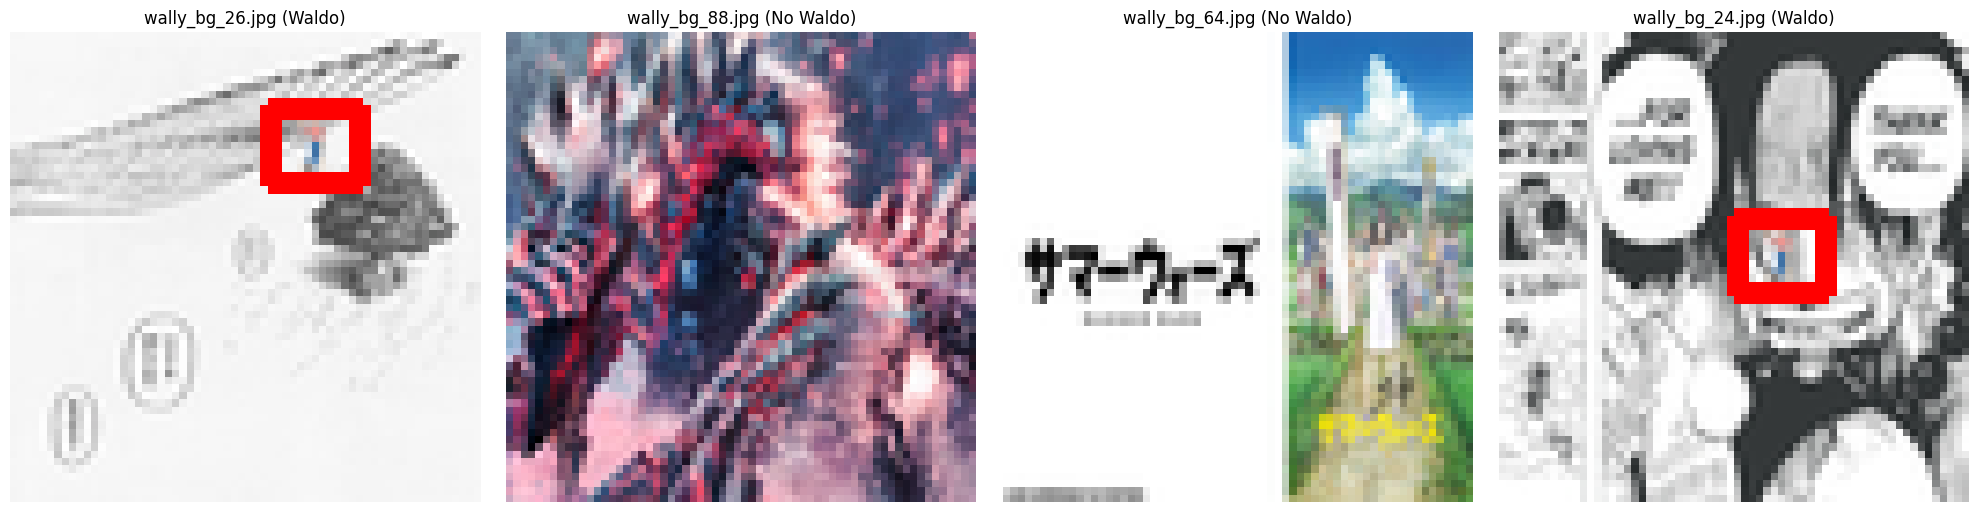


STEP 2: Data Augmentation
Applying data augmentation...
Successfully augmented 47 images
Updated annotations saved
Total images after augmentation: 136

Sample Augmented Images:


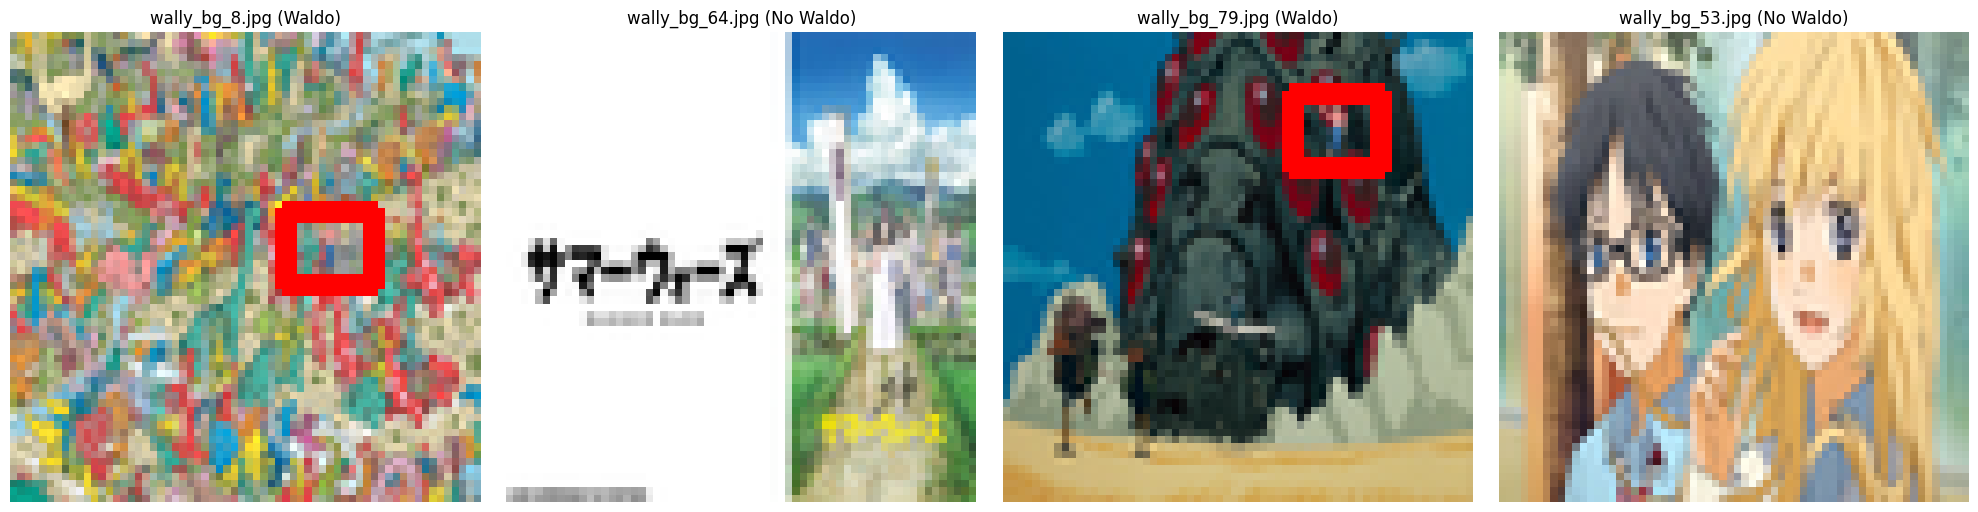


STEP 3: Data Splitting
Training samples: 95
Test samples: 41

Converting data to tensors...

STEP 4: Model Initialization
Total parameters: 11,242,566
Trainable parameters: 11,242,566

STEP 5: Training
Training for 300 epochs on cuda
Batch size: 8 (simulated)
Learning rate: 0.0001

Epoch 1/300
------------------------------
   Step  50: Loss=1.1936, Acc=0.5600
Epoch 1 Complete: Loss=1.1317, Acc=0.6632
Running validation...
Validation: Loss=3.7084, Acc=0.8049

Epoch 2/300
------------------------------
   Step  50: Loss=1.6573, Acc=0.7200
Epoch 2 Complete: Loss=1.3940, Acc=0.7263

Epoch 3/300
------------------------------
   Step  50: Loss=1.1243, Acc=0.7000
Epoch 3 Complete: Loss=1.1031, Acc=0.7263
Running validation...
Validation: Loss=1.0030, Acc=0.8049

Epoch 4/300
------------------------------
   Step  50: Loss=1.0995, Acc=0.7400
Epoch 4 Complete: Loss=1.1100, Acc=0.7263

Epoch 5/300
------------------------------
   Step  50: Loss=1.1195, Acc=0.7200
Epoch 5 Complete: Loss=1.099

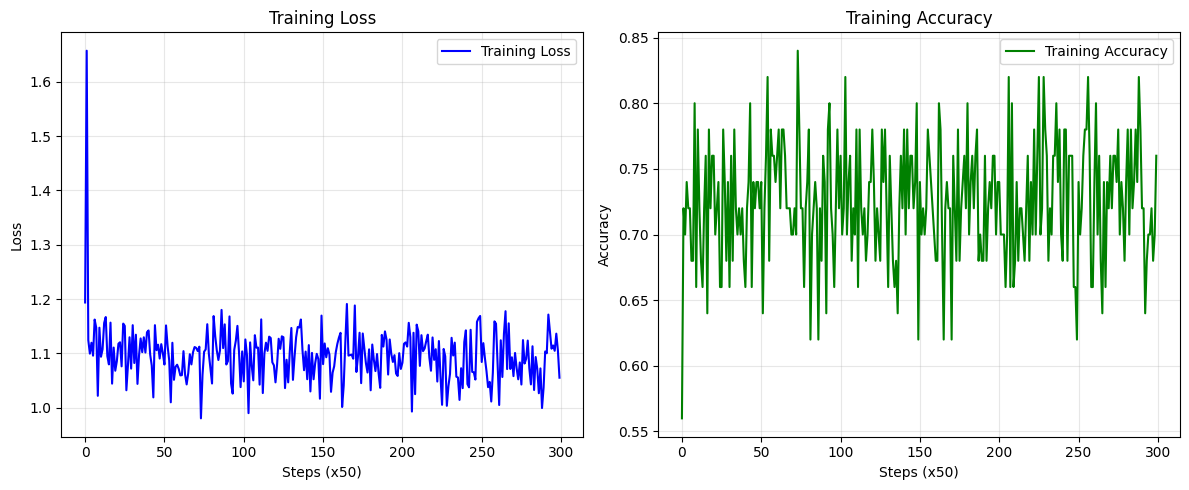


Saving model...

Training completed successfully!

Run the next cell to download your results!

TRAINING COMPLETED!
Final Loss: 1.0551
Final Accuracy: 0.7600

Your model is ready for Waldo detection!

Run download_results() to download your trained model!


In [101]:
# Run Setup and Training
# This cell runs the entire pipeline

print("Welcome to the Where's Waldo Detection Project!")
print("="*60)

# Setup Colab environment
if setup_colab_environment():

    # Optional: Mount Google Drive for persistence
    print("\nWould you like to mount Google Drive? (for persistent model storage)")
    print("   Run: mount_google_drive() if yes")

    # Run training
    print(f"\nStarting training...")
    model, losses, accuracies = main()

    # Show final results
    print("\n" + "="*60)
    print("TRAINING COMPLETED!")
    print("="*60)
    print(f"Final Loss: {losses[-1]:.4f}")
    print(f"Final Accuracy: {accuracies[-1]:.4f}")
    print("\nYour model is ready for Waldo detection!")

    # Option to download results
    print("\nRun download_results() to download your trained model!")

else:
    print("Setup failed. Please upload the required files and try again.")




## Congratulations!

Your Where's Waldo detection model is now trained! Here's what you can do next:

### Download Your Results
 Run this to download your trained model:
 ```python
 download_results()
 ```

### Test Your Model
```python
# Test on a sample image
 model.eval()
 with torch.no_grad():
     # Load a test image and run inference
     test_image = next(iter(test_tensors.values()))
     class_pred, bbox_pred = model(test_image)
     confidence = torch.softmax(class_pred, dim=1).max().item()
     print(f"Prediction confidence: {confidence:.2f}")
```

### Save to Google Drive
 ```python
 # Mount drive and save
 mount_google_drive()
 torch.save(model.state_dict(), '/content/drive/MyDrive/waldo_model.pth')
```

 ### Model Performance
 Your model combines:
 - **Classification**: Determines if Waldo is present
 - **Bounding Box Regression**: Locates Waldo in the image
 - **Data Augmentation**: Improves generalization

### Next Steps
 1. Download the model weights
 2. Test on new images
 3. Fine-tune with more data
 4. Deploy for real-time detection
